# Android Pattern Lock Generator

This notebook generates and visualizes all possible Android pattern lock combinations on a 3x3 grid (9 dots).

## Rules:
- Connect dots in a sequence
- Cannot skip a dot that's between two dots unless it's already been visited
- Minimum pattern length: 4 dots
- Maximum pattern length: 9 dots


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, FancyArrowPatch
from itertools import combinations
import time

# Set up the 3x3 grid positions
GRID_SIZE = 3
DOT_POSITIONS = {
    1: (0, 0), 2: (0, 1), 3: (0, 2),
    4: (1, 0), 5: (1, 1), 6: (1, 2),
    7: (2, 0), 8: (2, 1), 9: (2, 2)
}

# Define which dots are between other dots (for skip validation)
BETWEEN_DOTS = {
    (1, 3): 2, (3, 1): 2,
    (1, 7): 4, (7, 1): 4,
    (1, 9): 5, (9, 1): 5,
    (2, 8): 5, (8, 2): 5,
    (3, 7): 5, (7, 3): 5,
    (3, 9): 6, (9, 3): 6,
    (4, 6): 5, (6, 4): 5,
    (7, 9): 8, (9, 7): 8
}

print("Setup complete!")
print(f"Grid size: {GRID_SIZE}x{GRID_SIZE}")
print(f"Total dots: {len(DOT_POSITIONS)}")


Setup complete!
Grid size: 3x3
Total dots: 9


In [ ]:
def is_valid_move(from_dot, to_dot, visited):
    """
    Check if moving from from_dot to to_dot is valid.
    A move is invalid if it skips a dot that's between them (collinear).
    You cannot skip a collinear dot even if it's already been visited.
    """
    if to_dot in visited:
        return False  # Can't visit the same dot twice
    
    # Check if there's a dot between from_dot and to_dot
    # If there is, you cannot skip it - must go through it
    if (from_dot, to_dot) in BETWEEN_DOTS:
        return False  # Cannot skip a collinear middle dot
    
    return True

def generate_all_patterns(min_length=4, max_length=9):
    """
    Generate all valid pattern lock combinations using backtracking.
    """
    all_patterns = []
    
    def backtrack(current_pattern, visited):
        # If pattern length is valid, save it
        if len(current_pattern) >= min_length:
            all_patterns.append(tuple(current_pattern))
        
        # If we've reached max length, stop
        if len(current_pattern) >= max_length:
            return
        
        # Try all possible next moves
        for next_dot in range(1, 10):
            if is_valid_move(current_pattern[-1], next_dot, visited):
                current_pattern.append(next_dot)
                visited.add(next_dot)
                backtrack(current_pattern, visited)
                # Backtrack
                current_pattern.pop()
                visited.remove(next_dot)
    
    # Start from each dot
    for start_dot in range(1, 10):
        backtrack([start_dot], {start_dot})
    
    return all_patterns

print("Pattern generation functions defined!")


Pattern generation functions defined!


In [3]:
# Generate all patterns
print("Generating all possible patterns...")
start_time = time.time()
all_patterns = generate_all_patterns(min_length=4, max_length=9)
generation_time = time.time() - start_time

print(f"\nGeneration complete!")
print(f"Total patterns generated: {len(all_patterns):,}")
print(f"Time taken: {generation_time:.2f} seconds")

# Count patterns by length
pattern_counts = {}
for pattern in all_patterns:
    length = len(pattern)
    pattern_counts[length] = pattern_counts.get(length, 0) + 1

print("\nPattern distribution by length:")
for length in sorted(pattern_counts.keys()):
    print(f"  Length {length}: {pattern_counts[length]:,} patterns")


Generating all possible patterns...

Generation complete!
Total patterns generated: 389,112
Time taken: 0.44 seconds

Pattern distribution by length:
  Length 4: 1,624 patterns
  Length 5: 7,152 patterns
  Length 6: 26,016 patterns
  Length 7: 72,912 patterns
  Length 8: 140,704 patterns
  Length 9: 140,704 patterns


In [4]:
def visualize_pattern(pattern, ax=None, title=None, show_dots=True, show_numbers=True):
    """
    Visualize a single pattern lock.
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 6))
    
    # Draw grid lines
    for i in range(GRID_SIZE + 1):
        ax.axhline(i - 0.5, color='gray', linestyle='--', linewidth=0.5, alpha=0.3)
        ax.axvline(i - 0.5, color='gray', linestyle='--', linewidth=0.5, alpha=0.3)
    
    # Draw dots
    if show_dots:
        for dot_num, (x, y) in DOT_POSITIONS.items():
            circle = Circle((y, 2-x), 0.15, color='black', fill=True, zorder=3)
            ax.add_patch(circle)
            
            if show_numbers:
                ax.text(y, 2-x, str(dot_num), ha='center', va='center', 
                       color='white', fontsize=10, fontweight='bold', zorder=4)
    
    # Draw pattern path
    if len(pattern) > 1:
        for i in range(len(pattern) - 1):
            from_dot = pattern[i]
            to_dot = pattern[i + 1]
            from_pos = DOT_POSITIONS[from_dot]
            to_pos = DOT_POSITIONS[to_dot]
            
            # Convert to plot coordinates (flip y-axis)
            from_plot = (from_pos[1], 2 - from_pos[0])
            to_plot = (to_pos[1], 2 - to_pos[0])
            
            # Draw arrow
            arrow = FancyArrowPatch(from_plot, to_plot,
                                   arrowstyle='->', mutation_scale=20,
                                   color='blue', linewidth=2.5, zorder=2)
            ax.add_patch(arrow)
    
    # Highlight visited dots
    for dot_num in pattern:
        x, y = DOT_POSITIONS[dot_num]
        circle = Circle((y, 2-x), 0.2, color='red', fill=False, 
                       linewidth=3, zorder=3)
        ax.add_patch(circle)
    
    ax.set_xlim(-0.5, 2.5)
    ax.set_ylim(-0.5, 2.5)
    ax.set_aspect('equal')
    ax.axis('off')
    
    if title:
        ax.set_title(title, fontsize=12, fontweight='bold')
    
    return ax

def visualize_multiple_patterns(patterns, n_cols=5, figsize=(15, 3)):
    """
    Visualize multiple patterns in a grid.
    """
    n_patterns = len(patterns)
    n_rows = (n_patterns + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(figsize[0], figsize[1] * n_rows))
    
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    
    for idx, pattern in enumerate(patterns):
        row = idx // n_cols
        col = idx % n_cols
        ax = axes[row, col]
        
        title = f"{' → '.join(map(str, pattern))}"
        visualize_pattern(pattern, ax, title, show_numbers=False)
    
    # Hide unused subplots
    for idx in range(n_patterns, n_rows * n_cols):
        row = idx // n_cols
        col = idx % n_cols
        axes[row, col].axis('off')
    
    plt.tight_layout()
    plt.show()

print("Visualization functions defined!")


Visualization functions defined!


## Line Detection and Filtering

Functions to detect lines in patterns and filter patterns with exactly 3 lines.


In [ ]:
# Define all possible lines in a 3x3 grid
# A line is a set of dots that are collinear (horizontal, vertical, or diagonal)
LINES = [
    # Horizontal lines
    {1, 2, 3},
    {4, 5, 6},
    {7, 8, 9},
    # Vertical lines
    {1, 4, 7},
    {2, 5, 8},
    {3, 6, 9},
    # Diagonal lines
    {1, 5, 9},
    {3, 5, 7}
]

def dots_are_collinear(dot1, dot2, dot3=None):
    """
    Check if dots are on the same line.
    If dot3 is None, check if dot1 and dot2 are on any line together.
    """
    if dot3 is None:
        # Check if dot1 and dot2 are on any line together
        for line in LINES:
            if dot1 in line and dot2 in line:
                return True
        return False
    else:
        # Check if all three dots are on the same line
        for line in LINES:
            if dot1 in line and dot2 in line and dot3 in line:
                return True
        return False

def all_dots_on_same_line(dots):
    """
    Check if all dots in the list are on the same line.
    Returns True if there exists a line that contains all dots.
    """
    if len(dots) < 2:
        return True
    if len(dots) == 2:
        return dots_are_collinear(dots[0], dots[1])
    
    # Check if all dots are on the same line
    for line in LINES:
        if all(dot in line for dot in dots):
            return True
    return False

def count_lines_in_pattern(pattern):
    """
    Count the number of distinct lines in a pattern.
    A line is a sequence of consecutive dots that are collinear.
    Multiple consecutive collinear dots count as 1 line (e.g., 1-2-3 = 1 line).
    When collinearity breaks, a new line segment starts.
    Each line segment counts as 1 line.
    """
    if len(pattern) < 2:
        return 0
    
    lines_found = []
    i = 0
    
    while i < len(pattern) - 1:
        # Start of a potential line
        line_dots = [pattern[i]]
        j = i + 1
        
        # Extend the line as long as consecutive dots are collinear
        # All dots in the line must be on the same line
        while j < len(pattern):
            # Check if we can add pattern[j] to the current line
            # All dots in line_dots + pattern[j] must be on the same line
            test_line = line_dots + [pattern[j]]
            if all_dots_on_same_line(test_line):
                line_dots.append(pattern[j])
                j += 1
            else:
                break
        
        # If we found a collinear sequence with at least 2 dots, it's one line
        if len(line_dots) >= 2:
            # Create a canonical representation of the line (sorted tuple)
            line_key = tuple(sorted(line_dots))
            lines_found.append(line_key)
            # Move to the position after the last dot of this line
            # The last dot can be the start of the next line segment
            i = j - 1  # Move to the last dot of the line (it can be start of next line)
        else:
            # No collinear continuation found
            # Check if the next dot forms a 2-dot collinear pair
            if j < len(pattern):
                # Check if pattern[i] and pattern[j] are collinear
                if dots_are_collinear(pattern[i], pattern[j]):
                    # They form a 2-dot line
                    line_key = tuple(sorted([pattern[i], pattern[j]]))
                    lines_found.append(line_key)
                    i = j  # Move to pattern[j]
                else:
                    # Not collinear, but still counts as a line segment (2-dot connection)
                    line_key = tuple(sorted([pattern[i], pattern[j]]))
                    lines_found.append(line_key)
                    i = j
            else:
                i += 1
        
        # If we've reached the end, break
        if i >= len(pattern) - 1:
            break
    
    return len(lines_found)

def get_pattern_lines(pattern):
    """
    Get the list of lines in a pattern.
    Returns a list of tuples, each tuple representing a line (sorted dot numbers).
    Multiple consecutive collinear dots count as 1 line.
    """
    if len(pattern) < 2:
        return []
    
    lines_found = []
    i = 0
    
    while i < len(pattern) - 1:
        # Start of a potential line
        line_dots = [pattern[i]]
        j = i + 1
        
        # Extend the line as long as consecutive dots are collinear
        # All dots in the line must be on the same line
        while j < len(pattern):
            # Check if we can add pattern[j] to the current line
            # All dots in line_dots + pattern[j] must be on the same line
            test_line = line_dots + [pattern[j]]
            if all_dots_on_same_line(test_line):
                line_dots.append(pattern[j])
                j += 1
            else:
                break
        
        # If we found a collinear sequence with at least 2 dots, it's one line
        if len(line_dots) >= 2:
            # Create a canonical representation of the line (sorted tuple)
            line_key = tuple(sorted(line_dots))
            lines_found.append(line_key)
            # Move to the position after the last dot of this line
            # The last dot can be the start of the next line segment
            i = j - 1  # Move to the last dot of the line (it can be start of next line)
        else:
            # No collinear continuation found
            # Check if the next dot forms a 2-dot collinear pair
            if j < len(pattern):
                # Check if pattern[i] and pattern[j] are collinear
                if dots_are_collinear(pattern[i], pattern[j]):
                    # They form a 2-dot line
                    line_key = tuple(sorted([pattern[i], pattern[j]]))
                    lines_found.append(line_key)
                    i = j  # Move to pattern[j]
                else:
                    # Not collinear, but still counts as a line segment (2-dot connection)
                    line_key = tuple(sorted([pattern[i], pattern[j]]))
                    lines_found.append(line_key)
                    i = j
            else:
                i += 1
        
        # If we've reached the end, break
        if i >= len(pattern) - 1:
            break
    
    return lines_found

# Test the line detection
test_patterns = [
    ([1, 2, 3], 1),  # One horizontal line
    ([1, 4, 7], 1),  # One vertical line
    ([1, 5, 9], 1),  # One diagonal line
    ([1, 2, 5, 8], 2),  # Line 1-2, then line 2-5-8 (vertical)
    ([1, 2, 3, 6, 9], 2),  # Line 1-2-3, then line 3-6-9 (vertical)
    ([1, 2, 3, 4], 1),  # Line 1-2-3 (horizontal), then 3-4 is NOT a line
    ([1, 2, 5, 4, 7], 3),  # Line 1-2, then 2-5, then 5-4-7 (vertical)
    ([1, 2, 3, 4, 5, 6, 7, 8, 9], 5),  # Lines: 1-2-3, 3-4, 4-5-6, 6-7, 7-8-9 (5 lines)
]

print("Testing line detection:")
for pattern, expected_lines in test_patterns:
    lines = count_lines_in_pattern(pattern)
    line_details = get_pattern_lines(pattern)
    status = "✓" if lines == expected_lines else "✗"
    print(f"{status} Pattern {pattern}: {lines} line(s) (expected {expected_lines})")
    print(f"    Lines: {line_details}")

# Test the specific pattern mentioned by user
print("\n\nTesting pattern 1-2-3-4-5-6-7-8-9:")
test_pattern = [1, 2, 3, 4, 5, 6, 7, 8, 9]
lines_count = count_lines_in_pattern(test_pattern)
lines_details = get_pattern_lines(test_pattern)
print(f"Detected {lines_count} lines: {lines_details}")
print(f"Expected: 5 lines (1-2-3, 3-4, 4-5-6, 6-7, 7-8-9)")

# Check each segment and show how lines are formed
print("\nAnalyzing line segments:")
i = 0
segment_num = 1
while i < len(test_pattern) - 1:
    line_dots = [test_pattern[i]]
    j = i + 1
    
    # Extend while collinear
    while j < len(test_pattern):
        test_line = line_dots + [test_pattern[j]]
        if all_dots_on_same_line(test_line):
            line_dots.append(test_pattern[j])
            j += 1
        else:
            break
    
    if len(line_dots) >= 2:
        print(f"  Line {segment_num}: {line_dots} (collinear: {all_dots_on_same_line(line_dots)})")
        segment_num += 1
        i = j - 1
    else:
        if j < len(test_pattern):
            print(f"  Line {segment_num}: [{test_pattern[i]}, {test_pattern[j]}] (2-dot segment)")
            segment_num += 1
            i = j
        else:
            i += 1
    
    if i >= len(test_pattern) - 1:
        break

# Test invalid pattern detection
print("\n\nTesting pattern validity:")
invalid_test_patterns = [
    ([7, 9], False),  # Can't go from 7 to 9 - must go through 8
    ([8, 7, 9], False),  # Can't go from 7 to 9 even if 8 is already visited
    ([1, 3], False),  # Can't go from 1 to 3 - must go through 2
    ([1, 2, 3], True),  # Valid: 1-2-3
    ([1, 4, 8, 9, 7], False),  # Invalid: 9 to 7 skips 8 (even though 8 was visited)
    ([1, 4, 8, 9, 8, 7], False),  # Invalid: visits 8 twice
]

for pattern, should_be_valid in invalid_test_patterns:
    # Check if pattern would be generated (all moves are valid)
    is_valid = True
    visited = {pattern[0]}
    for i in range(len(pattern) - 1):
        if not is_valid_move(pattern[i], pattern[i+1], visited):
            is_valid = False
            break
        visited.add(pattern[i+1])
    
    status = "✓" if is_valid == should_be_valid else "✗"
    print(f"{status} Pattern {pattern}: {'Valid' if is_valid else 'Invalid'} (expected {'Valid' if should_be_valid else 'Invalid'})")

print("\nLine detection functions ready!")


Testing line detection:
✓ Pattern [1, 2, 3]: 1 line(s) (expected 1)
    Lines: [(1, 2, 3)]
✓ Pattern [1, 4, 7]: 1 line(s) (expected 1)
    Lines: [(1, 4, 7)]
✓ Pattern [1, 5, 9]: 1 line(s) (expected 1)
    Lines: [(1, 5, 9)]
✓ Pattern [1, 2, 5, 8]: 2 line(s) (expected 2)
    Lines: [(1, 2), (2, 5, 8)]
✓ Pattern [1, 2, 3, 6, 9]: 2 line(s) (expected 2)
    Lines: [(1, 2, 3), (3, 6, 9)]
✗ Pattern [1, 2, 3, 4]: 2 line(s) (expected 1)
    Lines: [(1, 2, 3), (3, 4)]
✗ Pattern [1, 2, 5, 4, 7]: 4 line(s) (expected 3)
    Lines: [(1, 2), (2, 5), (4, 5), (4, 7)]
✓ Pattern [1, 2, 3, 4, 5, 6, 7, 8, 9]: 5 line(s) (expected 5)
    Lines: [(1, 2, 3), (3, 4), (4, 5, 6), (6, 7), (7, 8, 9)]


Testing pattern 1-2-3-4-5-6-7-8-9:
Detected 5 lines: [(1, 2, 3), (3, 4), (4, 5, 6), (6, 7), (7, 8, 9)]
Expected: 5 lines (1-2-3, 3-4, 4-5-6, 6-7, 7-8-9)

Analyzing line segments:
  Line 1: [1, 2, 3] (collinear: True)
  Line 2: [3, 4] (2-dot segment)
  Line 3: [4, 5, 6] (collinear: True)
  Line 4: [6, 7] (2-dot segm

In [6]:
# Filter patterns with exactly 3 lines
print("Filtering patterns with exactly 3 lines...")
start_time = time.time()

patterns_with_3_lines = []
for pattern in all_patterns:
    # Verify pattern is valid (all moves are legal)
    # All patterns in all_patterns should already be valid, but double-check
    is_valid_pattern = True
    visited = {pattern[0]}
    for i in range(len(pattern) - 1):
        if not is_valid_move(pattern[i], pattern[i+1], visited):
            is_valid_pattern = False
            break
        visited.add(pattern[i+1])
    
    if is_valid_pattern and count_lines_in_pattern(pattern) == 3:
        patterns_with_3_lines.append(pattern)

filter_time = time.time() - start_time

print(f"\nFiltering complete!")
print(f"Patterns with exactly 3 lines: {len(patterns_with_3_lines):,}")
print(f"Time taken: {filter_time:.2f} seconds")
print(f"Percentage of all patterns: {len(patterns_with_3_lines)/len(all_patterns)*100:.2f}%")

# Count by pattern length
three_line_counts = {}
for pattern in patterns_with_3_lines:
    length = len(pattern)
    three_line_counts[length] = three_line_counts.get(length, 0) + 1

print("\nPatterns with 3 lines - distribution by length:")
for length in sorted(three_line_counts.keys()):
    print(f"  Length {length}: {three_line_counts[length]:,} patterns")

# Verify no invalid patterns (like 7-9 without 8)
print("\nVerifying pattern validity...")
invalid_count = 0
for pattern in patterns_with_3_lines:
    visited = {pattern[0]}
    for i in range(len(pattern) - 1):
        if not is_valid_move(pattern[i], pattern[i+1], visited):
            invalid_count += 1
            print(f"  Invalid pattern found: {pattern}")
            break
        visited.add(pattern[i+1])

if invalid_count == 0:
    print("✓ All patterns are valid!")
else:
    print(f"✗ Found {invalid_count} invalid patterns")


Filtering patterns with exactly 3 lines...

Filtering complete!
Patterns with exactly 3 lines: 3,760
Time taken: 11.47 seconds
Percentage of all patterns: 0.97%

Patterns with 3 lines - distribution by length:
  Length 4: 1,320 patterns
  Length 5: 1,808 patterns
  Length 6: 584 patterns
  Length 7: 48 patterns

Verifying pattern validity...
✓ All patterns are valid!


Visualizing sample patterns with exactly 3 lines...



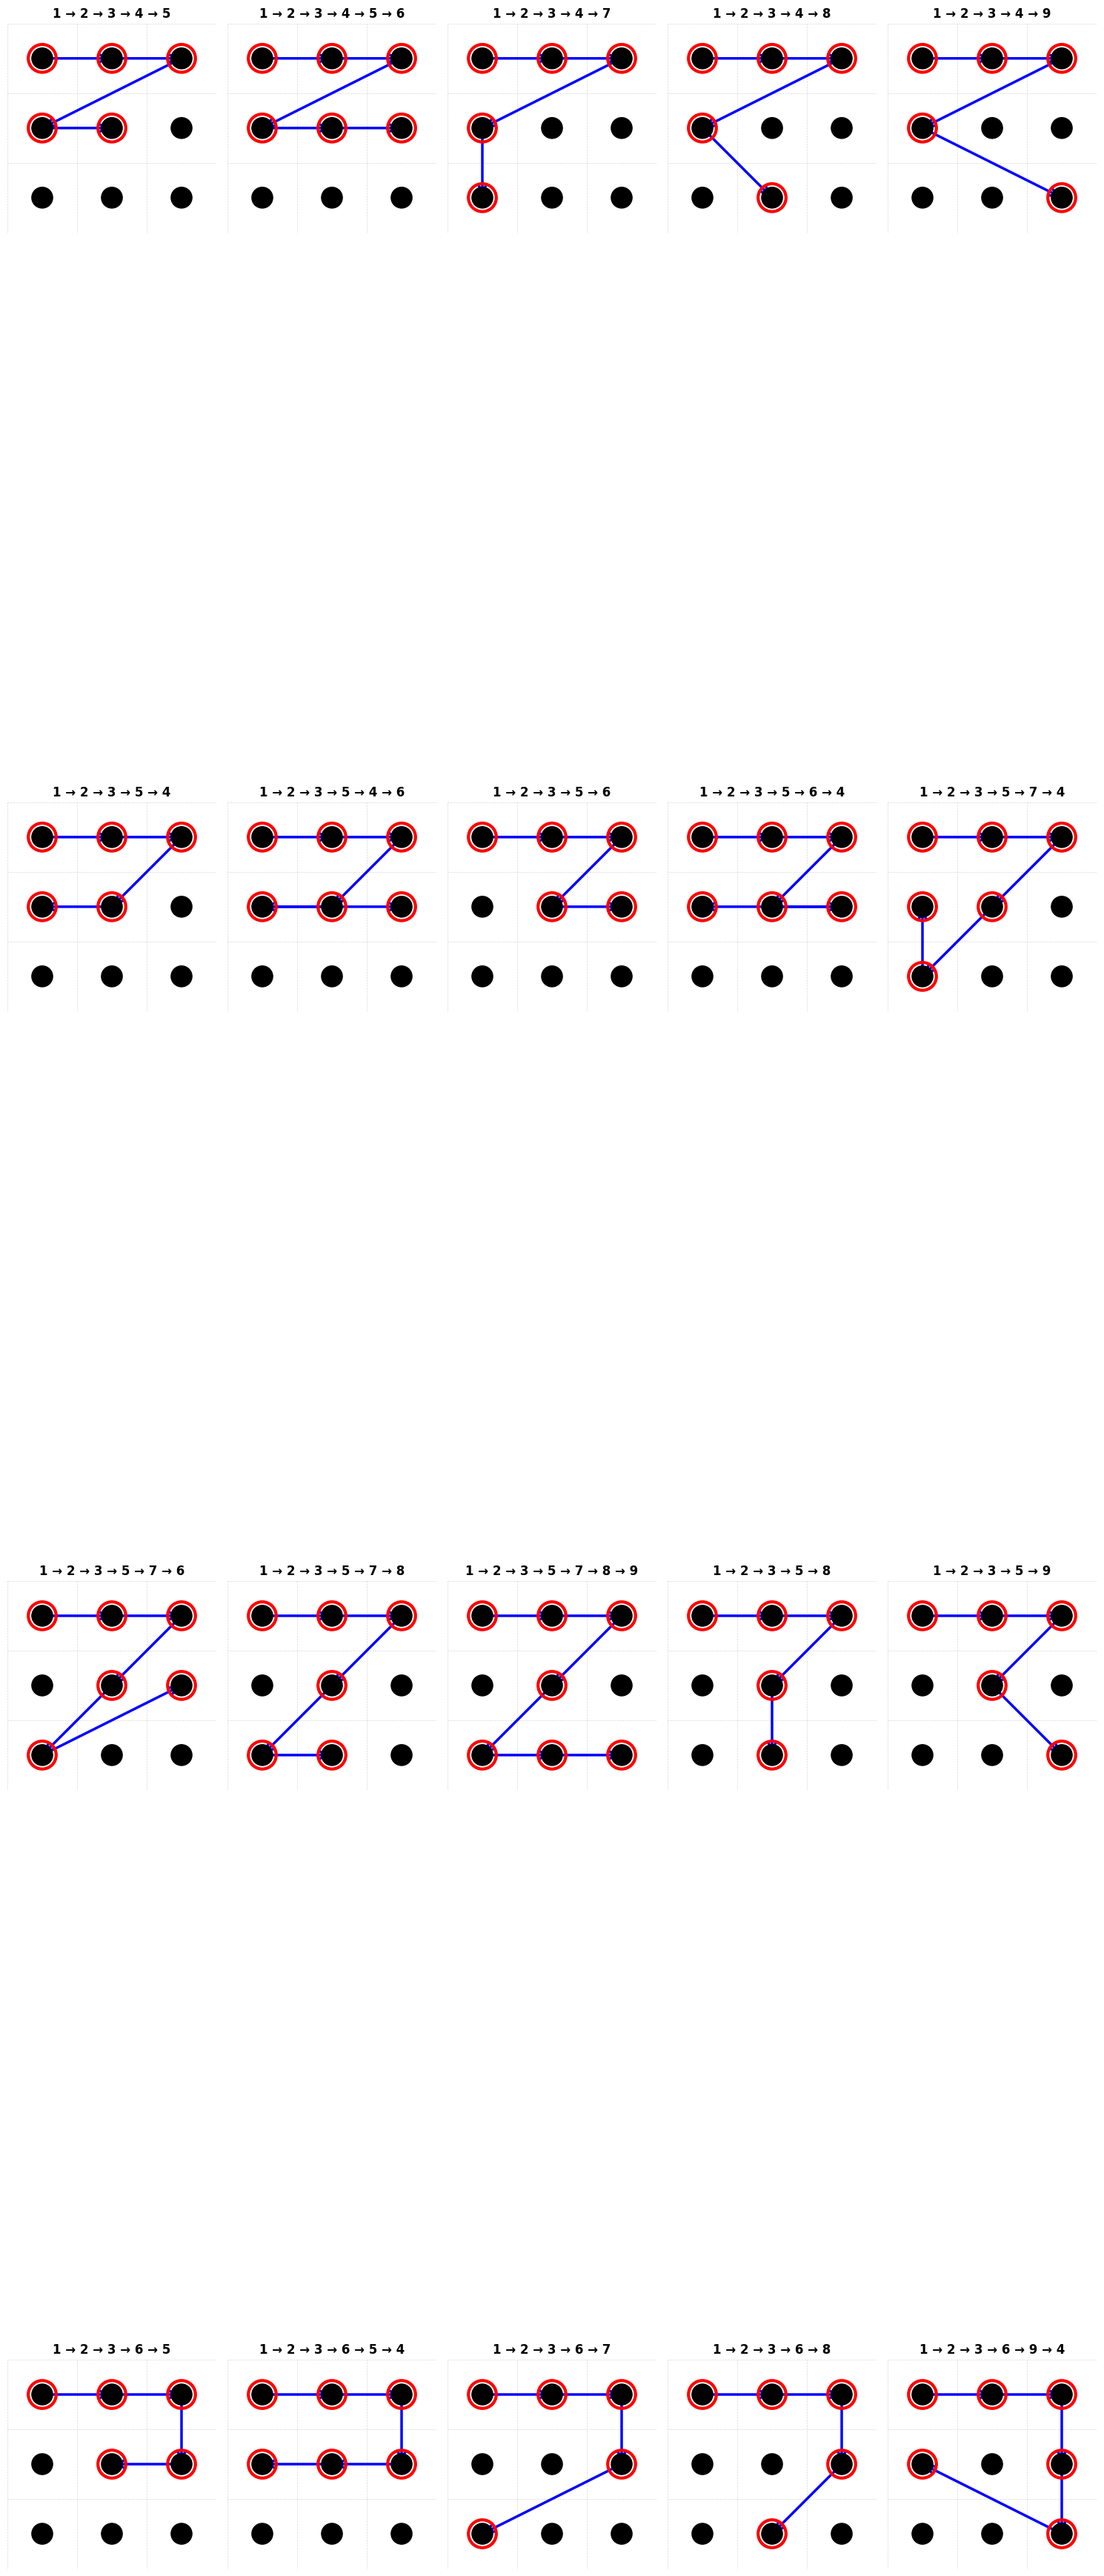


Details of first 5 patterns with 3 lines:

1. Pattern: 1 → 2 → 3 → 4 → 5 (Length: 5)
   Lines: [(1, 2, 3), (3, 4), (4, 5)]

2. Pattern: 1 → 2 → 3 → 4 → 5 → 6 (Length: 6)
   Lines: [(1, 2, 3), (3, 4), (4, 5, 6)]

3. Pattern: 1 → 2 → 3 → 4 → 7 (Length: 5)
   Lines: [(1, 2, 3), (3, 4), (4, 7)]

4. Pattern: 1 → 2 → 3 → 4 → 8 (Length: 5)
   Lines: [(1, 2, 3), (3, 4), (4, 8)]

5. Pattern: 1 → 2 → 3 → 4 → 9 (Length: 5)
   Lines: [(1, 2, 3), (3, 4), (4, 9)]


In [7]:
# Ensure visualization functions are available
if 'visualize_pattern' not in globals():
    def visualize_pattern(pattern, ax=None, title=None, show_dots=True, show_numbers=True):
        """
        Visualize a single pattern lock.
        """
        if ax is None:
            fig, ax = plt.subplots(figsize=(6, 6))
        
        # Draw grid lines
        for i in range(GRID_SIZE + 1):
            ax.axhline(i - 0.5, color='gray', linestyle='--', linewidth=0.5, alpha=0.3)
            ax.axvline(i - 0.5, color='gray', linestyle='--', linewidth=0.5, alpha=0.3)
        
        # Draw dots
        if show_dots:
            for dot_num, (x, y) in DOT_POSITIONS.items():
                circle = Circle((y, 2-x), 0.15, color='black', fill=True, zorder=3)
                ax.add_patch(circle)
                
                if show_numbers:
                    ax.text(y, 2-x, str(dot_num), ha='center', va='center', 
                           color='white', fontsize=10, fontweight='bold', zorder=4)
        
        # Draw pattern path
        if len(pattern) > 1:
            for i in range(len(pattern) - 1):
                from_dot = pattern[i]
                to_dot = pattern[i + 1]
                from_pos = DOT_POSITIONS[from_dot]
                to_pos = DOT_POSITIONS[to_dot]
                
                # Convert to plot coordinates (flip y-axis)
                from_plot = (from_pos[1], 2 - from_pos[0])
                to_plot = (to_pos[1], 2 - to_pos[0])
                
                # Draw arrow
                arrow = FancyArrowPatch(from_plot, to_plot,
                                       arrowstyle='->', mutation_scale=20,
                                       color='blue', linewidth=2.5, zorder=2)
                ax.add_patch(arrow)
        
        # Highlight visited dots
        for dot_num in pattern:
            x, y = DOT_POSITIONS[dot_num]
            circle = Circle((y, 2-x), 0.2, color='red', fill=False, 
                           linewidth=3, zorder=3)
            ax.add_patch(circle)
        
        ax.set_xlim(-0.5, 2.5)
        ax.set_ylim(-0.5, 2.5)
        ax.set_aspect('equal')
        ax.axis('off')
        
        if title:
            ax.set_title(title, fontsize=12, fontweight='bold')
        
        return ax

if 'visualize_multiple_patterns' not in globals():
    def visualize_multiple_patterns(patterns, n_cols=5, figsize=(15, 3)):
        """
        Visualize multiple patterns in a grid.
        """
        n_patterns = len(patterns)
        n_rows = (n_patterns + n_cols - 1) // n_cols
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(figsize[0], figsize[1] * n_rows))
        
        if n_rows == 1:
            axes = axes.reshape(1, -1)
        
        for idx, pattern in enumerate(patterns):
            row = idx // n_cols
            col = idx % n_cols
            ax = axes[row, col]
            
            title = f"{' → '.join(map(str, pattern))}"
            visualize_pattern(pattern, ax, title, show_numbers=False)
        
        # Hide unused subplots
        for idx in range(n_patterns, n_rows * n_cols):
            row = idx // n_cols
            col = idx % n_cols
            axes[row, col].axis('off')
        
        plt.tight_layout()
        plt.show()

# Visualize some examples of patterns with 3 lines
print("Visualizing sample patterns with exactly 3 lines...\n")

# Show first 20 examples
sample_3line_patterns = patterns_with_3_lines[:20]
visualize_multiple_patterns(sample_3line_patterns, n_cols=5, figsize=(15, 12))

# Show details for first few patterns
print("\nDetails of first 5 patterns with 3 lines:")
for i, pattern in enumerate(patterns_with_3_lines[:5], 1):
    lines = get_pattern_lines(pattern)
    print(f"\n{i}. Pattern: {' → '.join(map(str, pattern))} (Length: {len(pattern)})")
    print(f"   Lines: {lines}")


In [8]:
# Save patterns with 3 lines to a file
import json

patterns_3lines_list = [list(p) for p in patterns_with_3_lines]

with open('patterns_with_3_lines.json', 'w') as f:
    json.dump(patterns_3lines_list, f)

print(f"Saved {len(patterns_3lines_list):,} patterns with exactly 3 lines to 'patterns_with_3_lines.json'")

# Create detailed summary
summary_3lines = {
    'total_patterns_with_3_lines': len(patterns_3lines_list),
    'pattern_counts_by_length': three_line_counts,
    'min_length': min(len(p) for p in patterns_3lines_list) if patterns_3lines_list else 0,
    'max_length': max(len(p) for p in patterns_3lines_list) if patterns_3lines_list else 0,
    'percentage_of_all_patterns': len(patterns_3lines_list) / len(all_patterns) * 100
}

with open('patterns_3lines_summary.json', 'w') as f:
    json.dump(summary_3lines, f, indent=2)

print("Saved summary to 'patterns_3lines_summary.json'")


Saved 3,760 patterns with exactly 3 lines to 'patterns_with_3_lines.json'
Saved summary to 'patterns_3lines_summary.json'


Visualizing patterns with 3 lines (each line in different color):



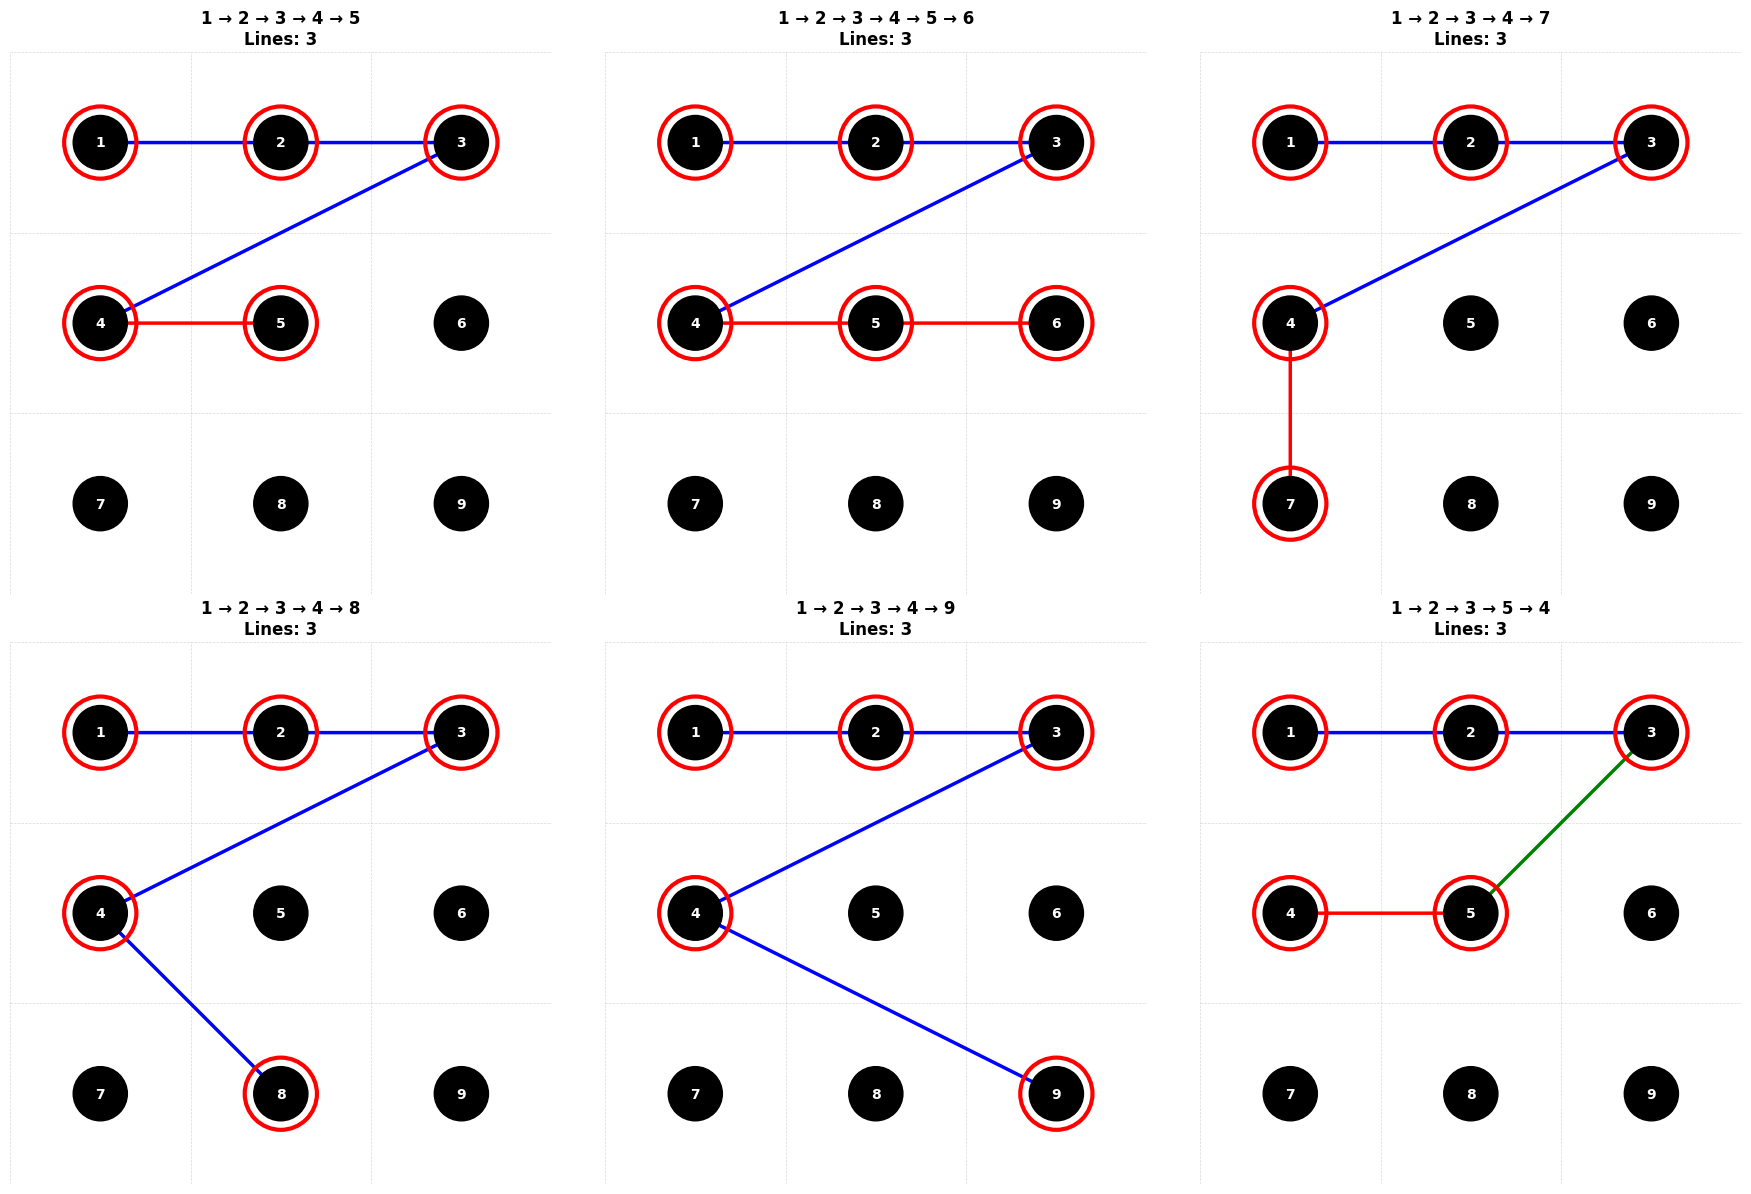

In [9]:
# Enhanced visualization showing lines with different colors
def visualize_pattern_with_lines(pattern, ax=None, title=None):
    """
    Visualize a pattern with different colors for each line.
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 6))
    
    lines = get_pattern_lines(pattern)
    
    # Draw grid lines
    for i in range(GRID_SIZE + 1):
        ax.axhline(i - 0.5, color='gray', linestyle='--', linewidth=0.5, alpha=0.3)
        ax.axvline(i - 0.5, color='gray', linestyle='--', linewidth=0.5, alpha=0.3)
    
    # Draw dots
    for dot_num, (x, y) in DOT_POSITIONS.items():
        circle = Circle((y, 2-x), 0.15, color='black', fill=True, zorder=3)
        ax.add_patch(circle)
        ax.text(y, 2-x, str(dot_num), ha='center', va='center', 
               color='white', fontsize=10, fontweight='bold', zorder=4)
    
    # Color palette for lines
    colors = ['blue', 'green', 'red', 'orange', 'purple', 'brown', 'pink', 'gray']
    
    # Draw pattern path with line colors
    if len(pattern) > 1:
        current_line_idx = 0
        line_start_idx = 0
        
        for i in range(len(pattern) - 1):
            from_dot = pattern[i]
            to_dot = pattern[i + 1]
            
            # Check if we're starting a new line
            if i > 0:
                prev_dot = pattern[i-1]
                if not dots_are_collinear(prev_dot, from_dot, to_dot):
                    # Check if from_dot and to_dot are on a line
                    if dots_are_collinear(from_dot, to_dot):
                        # Find which line this belongs to
                        for line_idx, line in enumerate(lines):
                            if from_dot in line and to_dot in line:
                                current_line_idx = line_idx
                                break
            
            from_pos = DOT_POSITIONS[from_dot]
            to_pos = DOT_POSITIONS[to_dot]
            from_plot = (from_pos[1], 2 - from_pos[0])
            to_plot = (to_pos[1], 2 - to_pos[0])
            
            # Use color based on current line
            color = colors[current_line_idx % len(colors)]
            arrow = FancyArrowPatch(from_plot, to_plot,
                                   arrowstyle='->', mutation_scale=20,
                                   color=color, linewidth=2.5, zorder=2)
            ax.add_patch(arrow)
    
    # Highlight visited dots
    for dot_num in pattern:
        x, y = DOT_POSITIONS[dot_num]
        circle = Circle((y, 2-x), 0.2, color='red', fill=False, 
                       linewidth=3, zorder=3)
        ax.add_patch(circle)
    
    ax.set_xlim(-0.5, 2.5)
    ax.set_ylim(-0.5, 2.5)
    ax.set_aspect('equal')
    ax.axis('off')
    
    if title:
        ax.set_title(title, fontsize=12, fontweight='bold')
    
    return ax

# Visualize a few patterns with 3 lines, showing each line in different color
print("Visualizing patterns with 3 lines (each line in different color):\n")
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

for idx, pattern in enumerate(patterns_with_3_lines[:6]):
    row = idx // 3
    col = idx % 3
    ax = axes[row, col]
    
    lines = get_pattern_lines(pattern)
    title = f"{' → '.join(map(str, pattern))}\nLines: {len(lines)}"
    visualize_pattern_with_lines(pattern, ax, title)

plt.tight_layout()
plt.show()


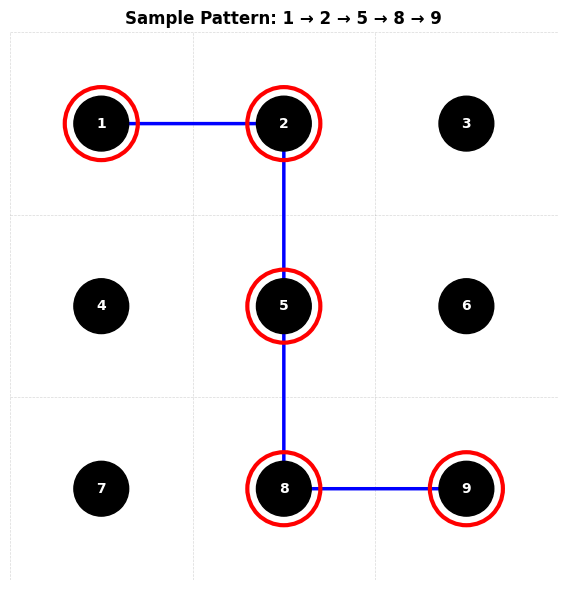

In [10]:
def visualize_pattern(pattern, ax=None, title=None, show_dots=True, show_numbers=True):
    """
    Visualize a single pattern lock.
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 6))
    
    # Draw grid lines
    for i in range(GRID_SIZE + 1):
        ax.axhline(i - 0.5, color='gray', linestyle='--', linewidth=0.5, alpha=0.3)
        ax.axvline(i - 0.5, color='gray', linestyle='--', linewidth=0.5, alpha=0.3)
    
    # Draw dots
    if show_dots:
        for dot_num, (x, y) in DOT_POSITIONS.items():
            circle = Circle((y, 2-x), 0.15, color='black', fill=True, zorder=3)
            ax.add_patch(circle)
            
            if show_numbers:
                ax.text(y, 2-x, str(dot_num), ha='center', va='center', 
                       color='white', fontsize=10, fontweight='bold', zorder=4)
    
    # Draw pattern path
    if len(pattern) > 1:
        for i in range(len(pattern) - 1):
            from_dot = pattern[i]
            to_dot = pattern[i + 1]
            from_pos = DOT_POSITIONS[from_dot]
            to_pos = DOT_POSITIONS[to_dot]
            
            # Convert to plot coordinates (flip y-axis)
            from_plot = (from_pos[1], 2 - from_pos[0])
            to_plot = (to_pos[1], 2 - to_pos[0])
            
            # Draw arrow
            arrow = FancyArrowPatch(from_plot, to_plot,
                                   arrowstyle='->', mutation_scale=20,
                                   color='blue', linewidth=2.5, zorder=2)
            ax.add_patch(arrow)
    
    # Highlight visited dots
    for dot_num in pattern:
        x, y = DOT_POSITIONS[dot_num]
        circle = Circle((y, 2-x), 0.2, color='red', fill=False, 
                       linewidth=3, zorder=3)
        ax.add_patch(circle)
    
    ax.set_xlim(-0.5, 2.5)
    ax.set_ylim(-0.5, 2.5)
    ax.set_aspect('equal')
    ax.axis('off')
    
    if title:
        ax.set_title(title, fontsize=12, fontweight='bold')
    
    return ax

# Test visualization with a sample pattern
sample_pattern = [1, 2, 5, 8, 9]
fig, ax = plt.subplots(figsize=(6, 6))
visualize_pattern(sample_pattern, ax, f"Sample Pattern: {' → '.join(map(str, sample_pattern))}")
plt.tight_layout()
plt.show()


Visualizing sample patterns...


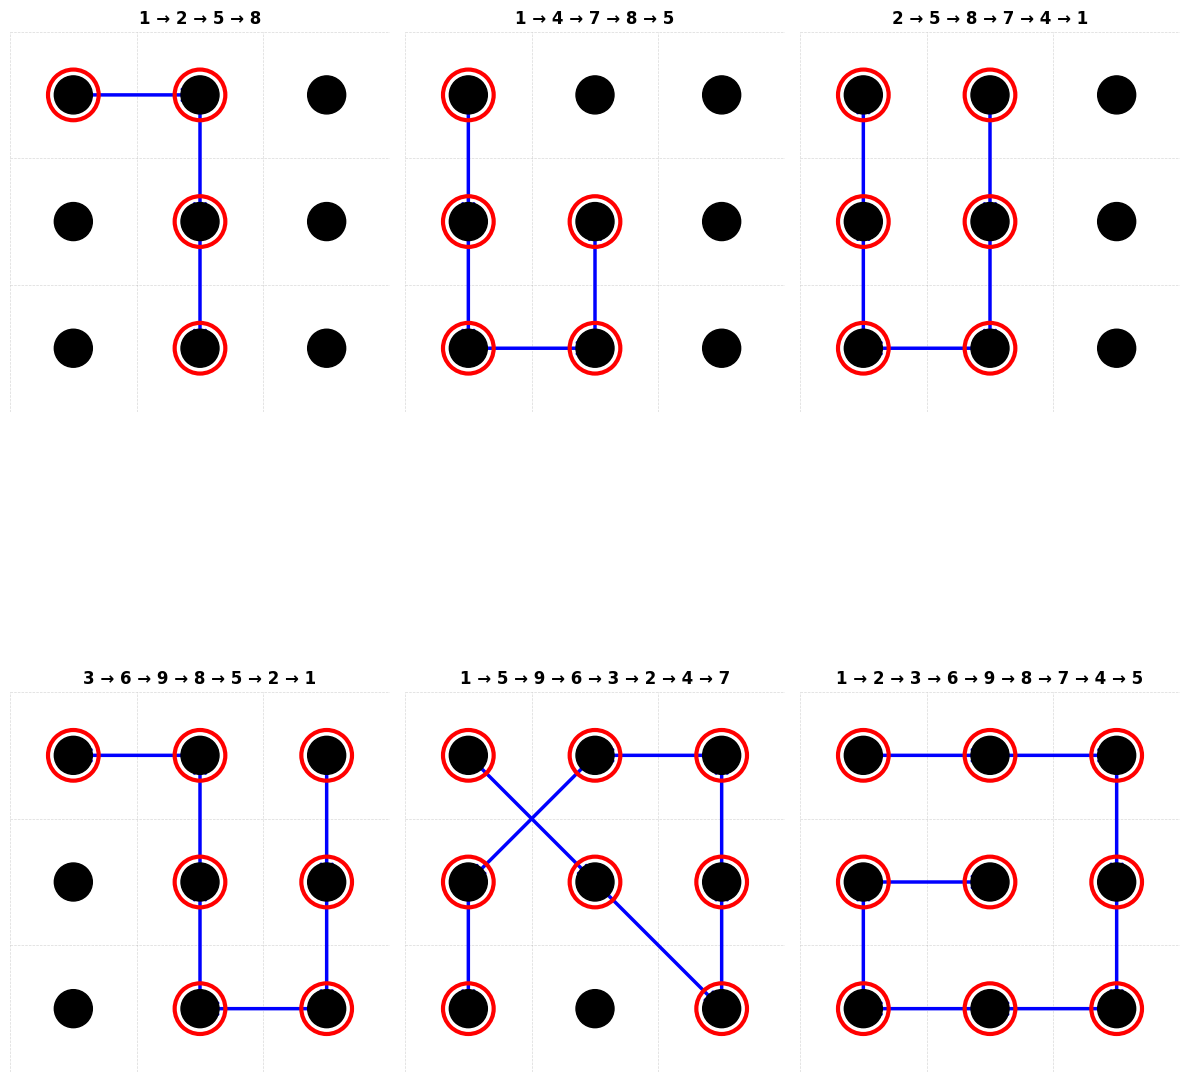

In [11]:
def visualize_multiple_patterns(patterns, n_cols=5, figsize=(15, 3)):
    """
    Visualize multiple patterns in a grid.
    """
    n_patterns = len(patterns)
    n_rows = (n_patterns + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(figsize[0], figsize[1] * n_rows))
    
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    
    for idx, pattern in enumerate(patterns):
        row = idx // n_cols
        col = idx % n_cols
        ax = axes[row, col]
        
        title = f"{' → '.join(map(str, pattern))}"
        visualize_pattern(pattern, ax, title, show_numbers=False)
    
    # Hide unused subplots
    for idx in range(n_patterns, n_rows * n_cols):
        row = idx // n_cols
        col = idx % n_cols
        axes[row, col].axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize some example patterns (all valid patterns with length >= 4)
print("Visualizing sample patterns...")
sample_patterns = [
    [1, 2, 5, 8],      # Length 4
    [1, 4, 7, 8, 5],   # Length 5
    [2, 5, 8, 7, 4, 1], # Length 6
    [3, 6, 9, 8, 5, 2, 1], # Length 7
    [1, 5, 9, 6, 3, 2, 4, 7], # Length 8
    [1, 2, 3, 6, 9, 8, 7, 4, 5] # Length 9 (full pattern)
]

visualize_multiple_patterns(sample_patterns, n_cols=3, figsize=(12, 8))


Visualizing patterns grouped by length...

Length 4 patterns (showing first 10):


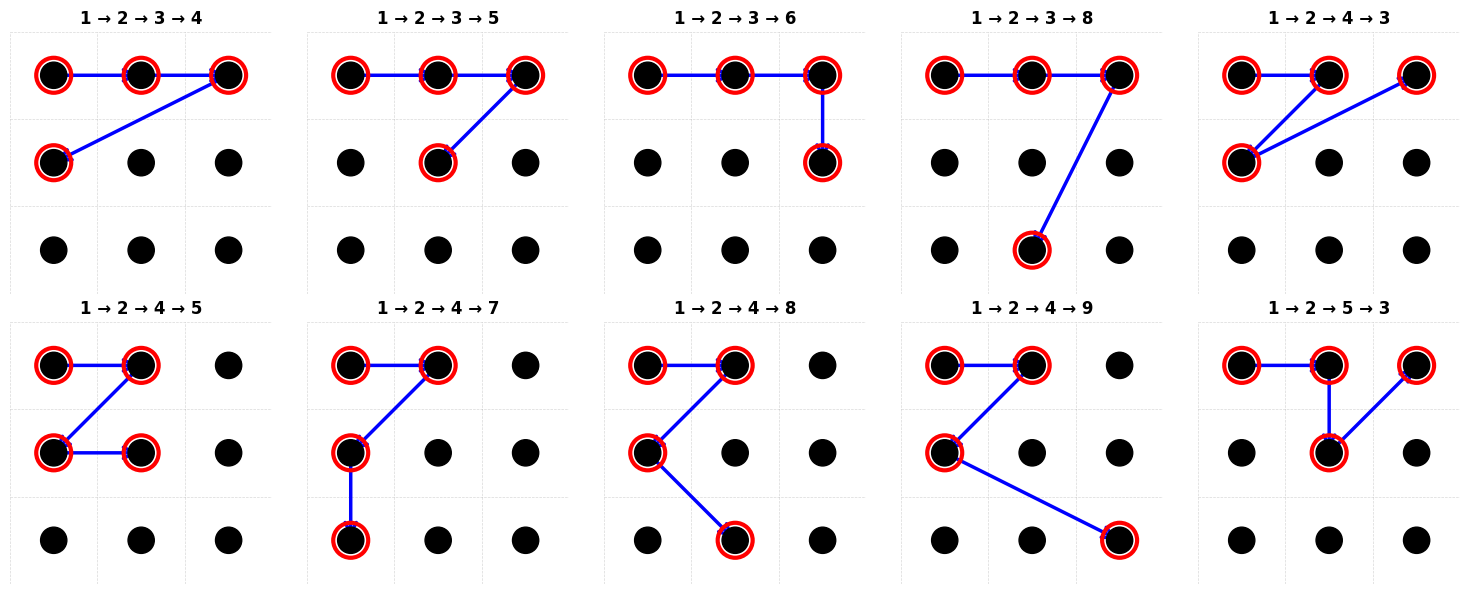


Length 5 patterns (showing first 10):


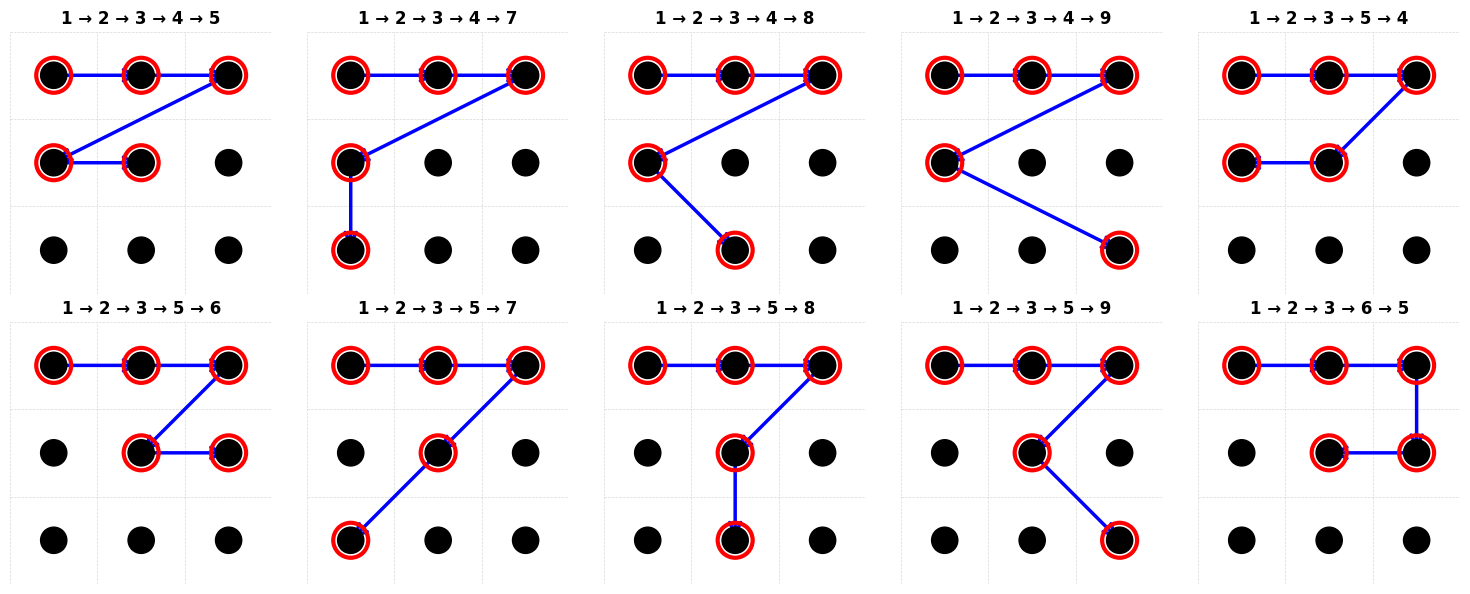


Length 6 patterns (showing first 10):


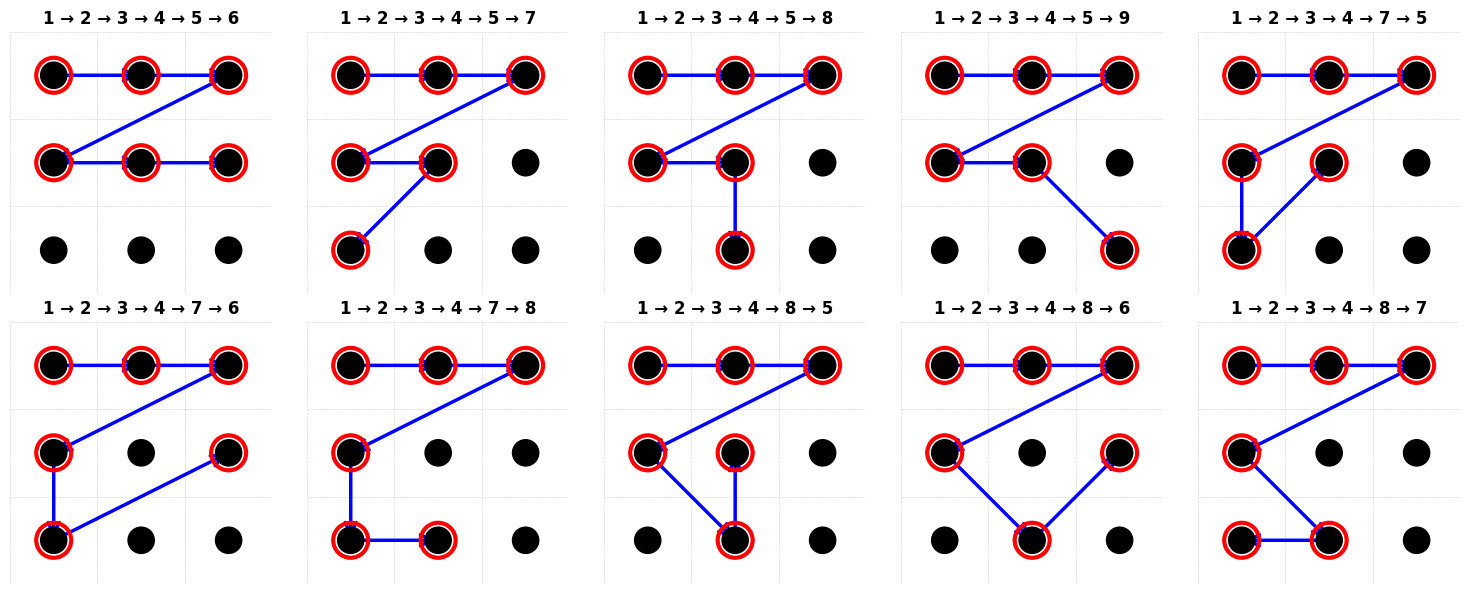


Length 7 patterns (showing first 10):


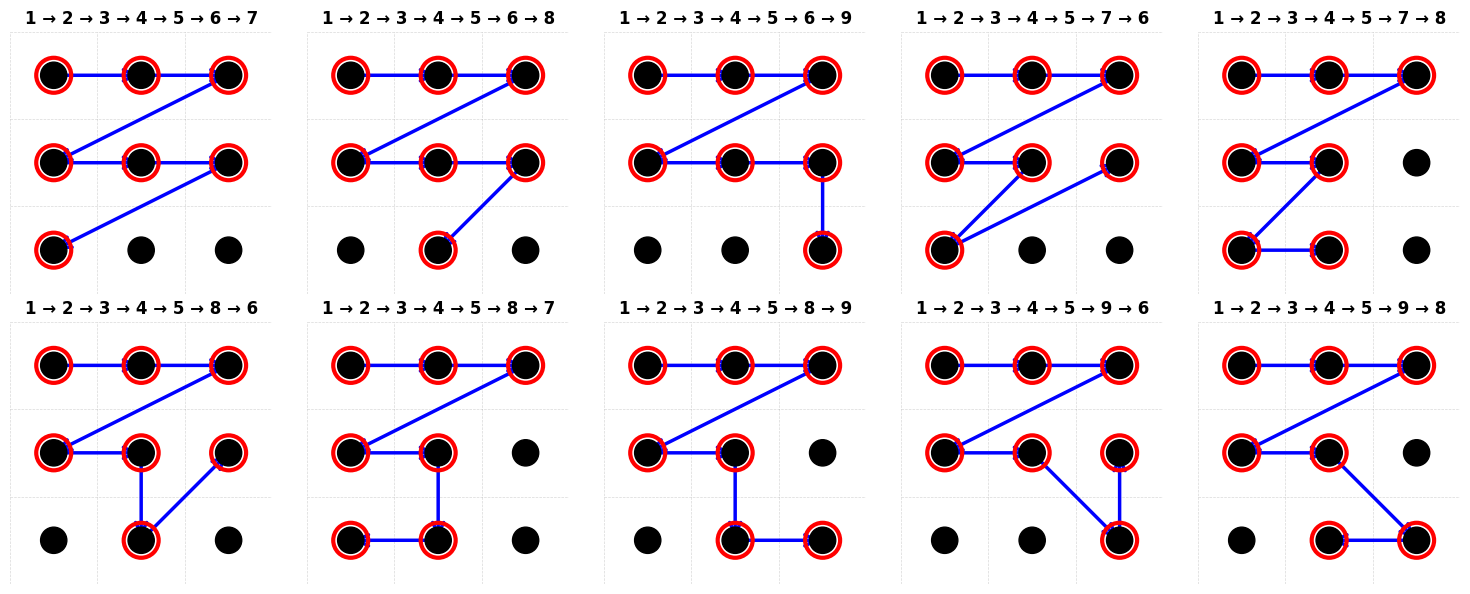


Length 8 patterns (showing first 10):


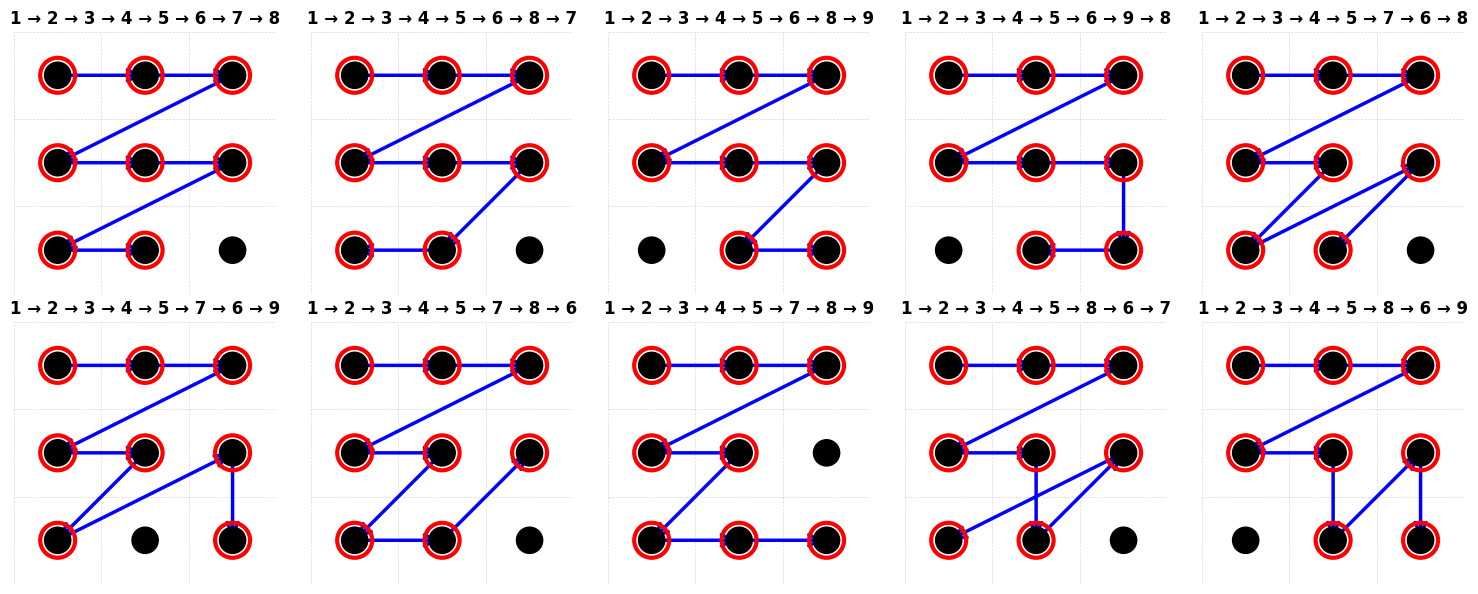


Length 9 patterns (showing first 10):


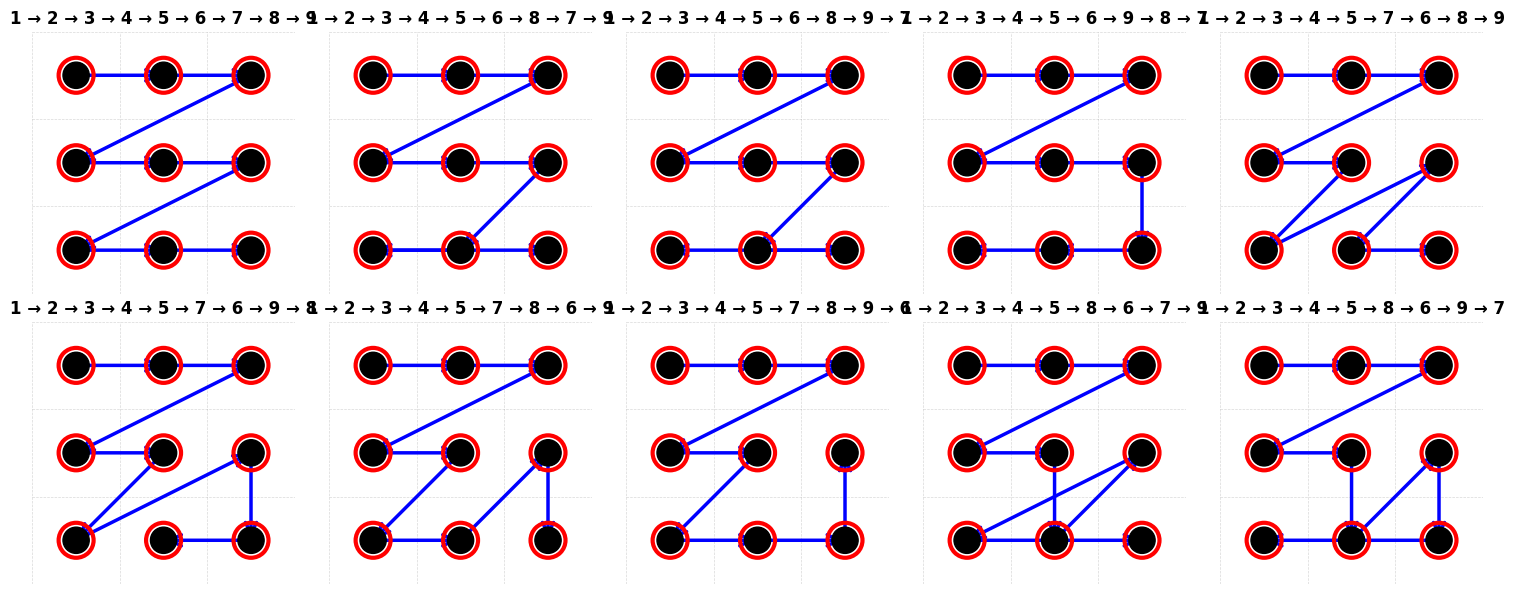

In [12]:
# Visualize patterns by length
print("Visualizing patterns grouped by length...\n")

for length in sorted(pattern_counts.keys()):
    print(f"Length {length} patterns (showing first 10):")
    patterns_of_length = [p for p in all_patterns if len(p) == length][:10]
    visualize_multiple_patterns(patterns_of_length, n_cols=5, figsize=(15, 3))
    print()


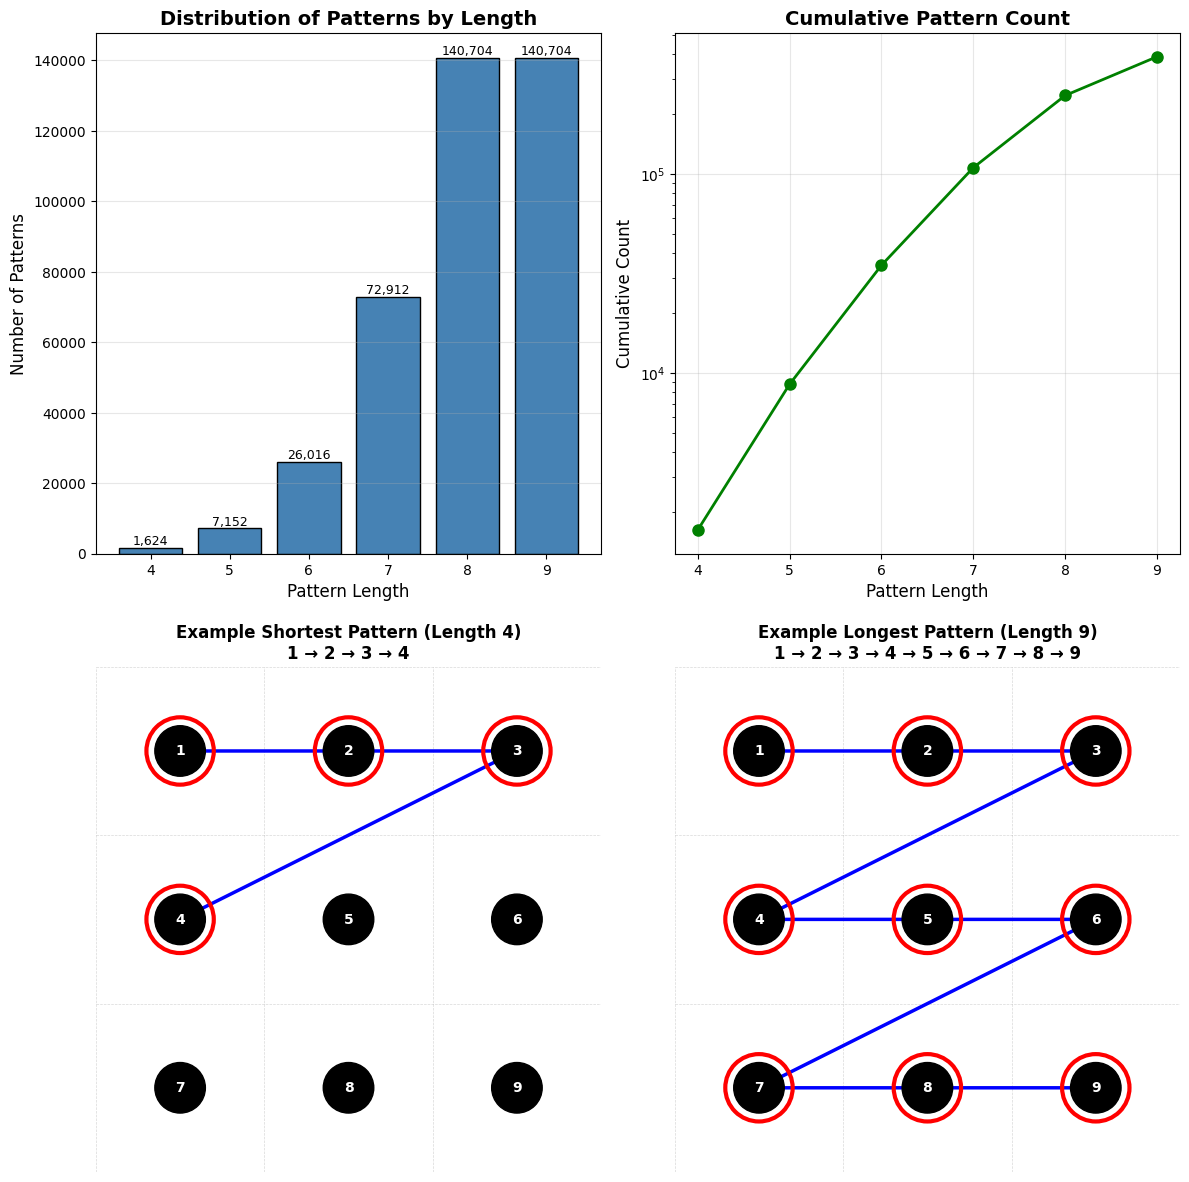


Total unique patterns: 389,112
Patterns range from length 4 to 9


In [13]:
# Create a summary visualization
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

# 1. Pattern length distribution
ax1 = axes[0, 0]
lengths = sorted(pattern_counts.keys())
counts = [pattern_counts[l] for l in lengths]
ax1.bar(lengths, counts, color='steelblue', edgecolor='black')
ax1.set_xlabel('Pattern Length', fontsize=12)
ax1.set_ylabel('Number of Patterns', fontsize=12)
ax1.set_title('Distribution of Patterns by Length', fontsize=14, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)
for i, (l, c) in enumerate(zip(lengths, counts)):
    ax1.text(l, c, f'{c:,}', ha='center', va='bottom', fontsize=9)

# 2. Cumulative count
ax2 = axes[0, 1]
cumulative = np.cumsum(counts)
ax2.plot(lengths, cumulative, marker='o', linewidth=2, markersize=8, color='green')
ax2.set_xlabel('Pattern Length', fontsize=12)
ax2.set_ylabel('Cumulative Count', fontsize=12)
ax2.set_title('Cumulative Pattern Count', fontsize=14, fontweight='bold')
ax2.grid(alpha=0.3)
ax2.set_yscale('log')

# 3. Example of shortest pattern
ax3 = axes[1, 0]
shortest_pattern = next(p for p in all_patterns if len(p) == 4)
visualize_pattern(shortest_pattern, ax3, 
                 f"Example Shortest Pattern (Length 4)\n{' → '.join(map(str, shortest_pattern))}")

# 4. Example of longest pattern
ax4 = axes[1, 1]
longest_pattern = next(p for p in all_patterns if len(p) == 9)
visualize_pattern(longest_pattern, ax4, 
                 f"Example Longest Pattern (Length 9)\n{' → '.join(map(str, longest_pattern))}")

plt.tight_layout()
plt.show()

print(f"\nTotal unique patterns: {len(all_patterns):,}")
print(f"Patterns range from length {min(len(p) for p in all_patterns)} to {max(len(p) for p in all_patterns)}")


In [14]:
# Save all patterns to a file (optional)
import json

# Convert patterns to lists for JSON serialization
patterns_list = [list(p) for p in all_patterns]

# Save to JSON file
with open('all_patterns.json', 'w') as f:
    json.dump(patterns_list, f)

print(f"Saved {len(patterns_list):,} patterns to 'all_patterns.json'")

# Also create a summary file
summary = {
    'total_patterns': len(patterns_list),
    'pattern_counts_by_length': pattern_counts,
    'min_length': min(len(p) for p in patterns_list),
    'max_length': max(len(p) for p in patterns_list)
}

with open('pattern_summary.json', 'w') as f:
    json.dump(summary, f, indent=2)

print("Saved summary to 'pattern_summary.json'")


Saved 389,112 patterns to 'all_patterns.json'
Saved summary to 'pattern_summary.json'


## Summary: Patterns with Exactly 3 Lines

All patterns with exactly 3 lines have been:
- ✅ Generated and filtered
- ✅ Visualized with line colors
- ✅ Saved to `patterns_with_3_lines.json`
- ✅ Summary saved to `patterns_3lines_summary.json`

You can access the list of all patterns with 3 lines using the variable `patterns_with_3_lines`.


In [15]:
# Interactive: Visualize specific patterns
def show_pattern(pattern_list):
    """Helper function to visualize a pattern from a list of dot numbers"""
    pattern = pattern_list if isinstance(pattern_list, list) else list(pattern_list)
    fig, ax = plt.subplots(figsize=(6, 6))
    title = f"Pattern: {' → '.join(map(str, pattern))} (Length: {len(pattern)})"
    visualize_pattern(pattern, ax, title)
    plt.tight_layout()
    plt.show()
    return pattern

# Example usage:
# show_pattern([1, 2, 5, 8, 9])
# show_pattern([7, 4, 1, 2, 3, 6, 9])

print("Helper function 'show_pattern()' is ready!")
print("You can use it like: show_pattern([1, 2, 5, 8, 9])")


Helper function 'show_pattern()' is ready!
You can use it like: show_pattern([1, 2, 5, 8, 9])


## Summary

This notebook has generated all possible Android pattern lock combinations. Key findings:

- **Total patterns**: All valid combinations from length 4 to 9
- **Pattern rules**: Cannot skip unvisited dots that are between two dots
- **Visualization**: Each pattern can be visualized showing the path and visited dots

### Usage:
- Use `show_pattern([dot1, dot2, ...])` to visualize any specific pattern
- All patterns are saved in `all_patterns.json`
- Summary statistics are in `pattern_summary.json`
